## <font color='#6629b2'>Reinforcement Learning - A Simple Python Example and a Step Closer to AI with Assisted Q-Learning</font>

This tutorial is based on [here](https://amunategui.github.io/reinforcement-learning/index.html)

Q-learning is a model-free reinforcement learning technique. Specifically, Q-learning can be used to find an optimal action-selection policy for any given (finite) [Markov decision process (MDP).](https://ko.wikipedia.org/wiki/%EB%A7%88%EB%A5%B4%EC%BD%94%ED%94%84_%EA%B2%B0%EC%A0%95_%EA%B3%BC%EC%A0%95) 
Machine learning is assumed to be either supervised or unsupervised but a recent new-comer broke the status-quo - reinforcement learning. Supervised and unsupervised approaches require data to model, not reinforcement learning! That’s right, it can explore space with a handful of instructions, analyze its surroundings one step at a time, and build data as it goes along for modeling.

In this walk-through, we’ll use Q-learning to find the shortest path between two areas. It has the ability to embark on a journey with no knowledge of what to do next. This approach requires constant trial and error as it collects data about its surroundings and figures out how to accomplish its goal. This opens up interesting possibilities, what about recording additional information, like environmental details along the way that it may not fully understand until after it reaches its goal? And once reached, could it review that additional data to determine if any of it would have helped it reach its goal faster?

In [1]:
import numpy as np
import pylab as plt
import networkx as nx

In [2]:
# map cell to cell, add circular cell to goal point

# graph 형태
points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)]

We create a points-list map that represents each direction our bot can take. Using this format allows us to easily create complex graphs but also easily visualize everything with networkx graphs.

Our starting point is 0, our goal point is 7.

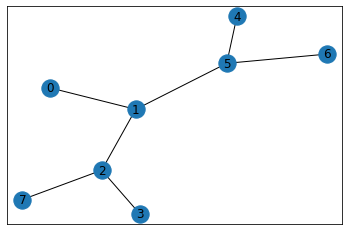

In [3]:
goal = 7

G=nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()

The map shows that point 0 is where our bot will start its journey and point 7 is it’s final goal. The extra added points and false paths are the obstacles the bot will have to contend with. If you look at the top image, we can weave a story into this search - our bot is looking for honey, it is trying to find the hive and avoid the factory (the story-line will make sense in the second half of the article).

We then create the rewards graph - this is the matrix version of our list of points map. We initialize the matrix to be the height and width of our points list (8 in this example) and initialize all values to -1:

In [4]:
# how many points in graph? x points
MATRIX_SIZE = 8

# create matrix x*y
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1
print(R)

[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


We then change the values to be 0 if it is a viable path and 100 if it is a goal path

In [5]:
# assign zeros to paths and 100 to goal-reaching point

# 목적지 도착하면 100의 보상, 가능한 길이면 0의 보상, 움직일 수 없는 길은 -1 의 보상
for point in points_list:
    print(point)
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        # reverse of point
        R[point[::-1]]= 0

# add goal point round trip
R[goal,goal]= 100

R

(0, 1)
(1, 5)
(5, 6)
(5, 4)
(1, 2)
(2, 3)
(2, 7)


matrix([[ -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [  0.,  -1.,   0.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,  -1.,   0.,  -1.,  -1.,  -1., 100.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,  -1.,  -1.,   0.,  -1.,   0.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1., 100.]])

To read the above matrix, the y-axis is the state or where your bot is currently located, and the x-axis is your possible next actions. We then build our Q-learning matrix which will hold all the lessons learned from our bot. The Q-learning model uses a transitional rule formula and gamma is the learning parameter

## Q-value 매트릭스 정의

- Q-value matrix 생성
    - 8개의 state, 8 by 8 matrix
    
- Available_actions
    - state 가 주어졌을 때 움직일 수 있는 set 을 찾아줌
    - ex) 현재 state=2 일 경우 3 or 7 로 이동 가능
    
- Sample_next_actions
    - 움직일 수 있는 경우의 수 중 랜덤하게 선택해 움직임
    - ex) (3, 7)이 가능하다면 둘 중 하나를 랜덤하게 선택

- update
    - 벨만 방정식 구현

In [6]:
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# learning parameter
gamma = 0.8 # 감가상각

initial_state = 1

def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

available_act = available_actions(initial_state) 

def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

action = sample_next_action(available_act)



def update(current_state, action, gamma):
    
  max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  
  if max_index.shape[0] > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q[action, max_index]
  
    # 벨만
  Q[current_state, action] = R[current_state, action] + gamma * max_value
  print('max_value', R[current_state, action] + gamma * max_value)
  
  if (np.max(Q) > 0):
    return(np.sum(Q/np.max(Q)*100))
  else:
    return (0)
    
update(initial_state, action, gamma)

max_value 0.0


0

run the training and testing functions that will run the update function 700 times allowing the Q-learning model to figure out the most efficient path:

## Training step
- 랜덤하게 current state 을 정함
- Current state에서 다음 action 을 취하여 Q-value 를 update 함
- 700 번의 training
- Update 마다 보상 값인 score 를 저장

max_value 0.0
Score: 0
max_value 100.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 80.0
Score: 180.0
max_value 64.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 100.0
Score: 244.0
max_value 100.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 80.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 80.0
Score: 324.0
max_value 0.0
Score: 324.0
max_value 64.0
Score: 388.0
max_value 80.0
Score: 388.0
max_value 80.0
Score: 388.0
max_value 64.0
Score: 388.0
max_value 100.0
Score: 488.0
max_value 64.0
Score: 488.0
max_value 180.0
Score: 315.55555555555554
max_value 0.0
Score: 315.55555555555554
max_value 144.0
Score: 351.1111111111111
max_value 144.0
Score: 431.1111111111111
max_value 0.0
Score: 431.1111111111111
max_value 0.0
Score: 431.1111111111111
max_value 144.0
Score: 431.1111111111111
max_value 64.0
Score: 431.1111111111111
max_value 115.2


Score: 982.4871330100111
max_value 255.8555892436221
Score: 982.4943561555799
max_value 399.77435819315946
Score: 982.4943561555799
max_value 319.8194865545276
Score: 982.4943561555799
max_value 255.8555892436221
Score: 982.4943561555799
max_value 399.77435819315946
Score: 982.4943561555799
max_value 255.8555892436221
Score: 982.5218943980603
max_value 255.8555892436221
Score: 982.5218943980603
max_value 319.8194865545276
Score: 982.5218943980603
max_value 399.77435819315946
Score: 982.5218943980603
max_value 255.8555892436221
Score: 982.5291175436291
max_value 399.77435819315946
Score: 982.5291175436291
max_value 319.8194865545276
Score: 982.5291175436291
max_value 204.68447139489768
Score: 982.5348960600841
max_value 255.8555892436221
Score: 982.5348960600841
max_value 319.8194865545276
Score: 982.5348960600841
max_value 399.77435819315946
Score: 982.5348960600841
max_value 399.77435819315946
Score: 982.5348960600841
max_value 255.8555892436221
Score: 982.5348960600841
max_value 319.

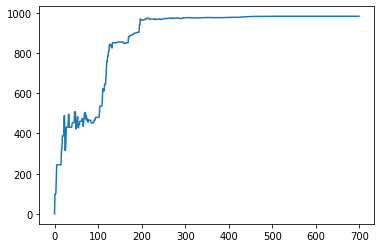

In [7]:
# Training
scores = []
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    print ('Score:', str(score))
    
print("Trained Q matrix:")
print(Q/np.max(Q)*100)

# Testing
current_state = 0
steps = [current_state]


while current_state != 7:

    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    
    steps.append(next_step_index)
    current_state = next_step_index

print("Most efficient path:")
print(steps)

plt.plot(scores)
plt.show()